# "Island" catchment areas

Ordinarily the catchment areas of each stroke unit don't match up nicely to other defined regions, for example the Integrated Care Boards or Ambulance Service boundaries.

Sometimes though it's preferable to only consider patients within a given region, even if patients outside the border would still ordinarily travel to a stroke unit within that region.

This is like pretending that everything outside the region doesn't exist. Outside the region, there are no LSOA with patients who will want to enter the region for treatment. Outside the region, there are no other stroke units that patients within the region might prefer to travel to. When the regions are split off like this, it is as though each one is its own island with nothing else surrounding it.

To create this effect with the catchment code, it is possible to restrict:
+ which stroke units are considered for each LSOA
+ which LSOA are considered

In this example we will restrict everything to the ISDN named "West Midlands".


## Notebook setup

In [1]:
import stroke_maps.load_data
import stroke_maps.catchment
import stroke_maps.geo

import pandas as pd
import matplotlib.pyplot as plt
from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

## Load data

__Stroke unit services__ for the calculations and __coordinates__ for the maps

In [2]:
df_units = stroke_maps.load_data.stroke_unit_region_lookup()

gdf_units = stroke_maps.load_data.stroke_unit_coordinates()
# Merge the services information into the coordinates:
gdf_units = pd.merge(
    gdf_units, df_units[['use_ivt', 'use_mt']],
    left_index=True, right_index=True, how='right'
)

__LSOA travel time__ for the calculations

In [3]:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()

__LSOA boundaries__ for the maps

In [4]:
gdf_lsoa = stroke_maps.load_data.lsoa_geography()

__ISDN boundaries__ for the maps

In [5]:
gdf_isdn = stroke_maps.load_data.isdn_geography()
# Only keep the chosen region:
gdf_isdn = gdf_isdn[gdf_isdn['isdn'] == 'West Midlands']

## Functions

Define functions that will be used to create catchment area boundaries and plot the map for both methods in the same way.

The following function creates the catchment area boundaries for the map. It has the same setup as the previous LSOA catchment documentation. __TO DO: add link__

In [6]:
def make_gdf(
        df_catchment_acute,  # Contains LSOA-unit link.
        gdf_lsoa
        ):
    """
    Make a GeoDataFrame of stroke unit catchment areas.
    """
    gdf_lsoa_acute = gdf_lsoa.copy()
    
    # Merge in the information on nearest acute stroke unit:
    gdf_lsoa_acute = pd.merge(
        gdf_lsoa_acute, df_catchment_acute['unit_postcode'],
        left_on='LSOA11NM', right_index=True, how='right'
    )
    # Combine LSOA with the same acute stroke unit into a single region:
    gdf_catchment_acute = stroke_maps.geo.combine_regions(gdf_lsoa_acute, 'unit_postcode')
    # Convert the coordinates to British National Grid so that they match other geometry:
    gdf_catchment_acute = gdf_catchment_acute.to_crs('EPSG:27700')
    # Assign colours:
    gdf_catchment_acute['adjacent_colours'] = greedy(
        gdf_catchment_acute, min_distance=1, balance='count').astype(str)
    # Assign these colours to the regions:
    gdf_catchment_acute['colour_str'] = gdf_catchment_acute['adjacent_colours'].map(colour_map)

    return gdf_catchment_acute

The following function plots the map:

In [7]:
def plot_catchment(
        gdf_catchment,
        gdf_isdn,
        gdf_units,
        postcodes_used=[],
        title='',
        bounds=[]
    ):
    """
    Plot catchment areas, stroke units, and ISDN boundary.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Catchment areas:
    gdf_catchment.plot(
        ax=ax,              # Set which axes to use for plot
        antialiased=False,  # Avoids artefact boundary lines
        color=gdf_catchment['colour_str'],  # set colours using this column
        linewidth=0.2,
        )
    
    # Setup for ISDN:
    kwargs_isdn = dict(
        facecolor='none',
        edgecolor='k',
        linewidth=0.2,
    )
    # ISDN outlines:
    gdf_isdn.plot(
        ax=ax,              # Set which axes to use for plot
        antialiased=False,  # Avoids artefact boundary lines
        **kwargs_isdn
        )
    # Can't put regions like this ^ in the legend, so fake it now.
    # Draw an area so small you'll never see it
    # and give it the same properties as the wanted region.
    points = [p for p in gdf_isdn['geometry'].iloc[0].exterior.coords]
    x = points[0][0]
    y = points[0][1]
    ax.fill(
        [x, x+1e-7],
        [y, y+1e-7],
        **kwargs_isdn,
        label='West Midlands ISDN'
    )

    if len(postcodes_used) > 0:
        # Limit the stroke units to only the ones used:
        gdf_units = gdf_units[gdf_units.index.isin(postcodes_used)]
    # Pick out which stroke units to plot:
    mask_ivt = ((gdf_units['use_ivt'] == 1) & (gdf_units['use_mt'] == 0))
    mask_mt = (gdf_units['use_mt'] == 1)
    
    # IVT units:
    ax.scatter(
        gdf_units.loc[mask_ivt, 'geometry'].x,
        gdf_units.loc[mask_ivt, 'geometry'].y,
        marker='o',
        facecolor='k',
        label='IVT unit',
        s=20,  # size
        )
    
    # MT units:
    ax.scatter(
        gdf_units.loc[mask_mt, 'geometry'].x,
        gdf_units.loc[mask_mt, 'geometry'].y,
        marker='*',
        facecolor='k',
        label='MT unit',
        s=40,  # size
        )

    # Axis limits:
    if len(bounds) > 0:
        ax.set_xlim(bounds[0], bounds[2])
        ax.set_ylim(bounds[1], bounds[3])

    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    
    # Add legend:
    ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    
    plt.show()

The following colour list is used to colour the catchment areas in the maps.

In [8]:
# Make a list of colour names:
# Expecting to only need a few colours for this example.
colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid', 'Orchid', 'Plum', 'Lavender']

# Make a dictionary of numbers to colours.
# The keys are the numbers in the `adjacent_colours` column:
keys = [f'{i}' for i in range(len(colours))]
colour_map = dict(zip(keys, colours))

## Method 1: nearest stroke unit

First we'll create a map of the normal stroke unit catchment areas in the West Midlands when we don't restrict anything.

Limit the travel time matrix to only stroke units that offer acute care. These are units where `use_ivt` and/or `use_mt` are equal to 1 (one).

In [9]:
mask_acute = ((df_units['use_ivt'] == 1) | (df_units['use_mt'] == 1))
postcodes_acute_units = df_units[mask_acute].index.values

# Load the travel time matrix:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()
# Limit it to these units:
df_travel_lsoa_acute = df_travel_lsoa[postcodes_acute_units].copy()

Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [10]:
df_catchment_acute = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa_acute)

Limit this results dataframe to only stroke units in the chosen region:

In [11]:
# Which postcodes are in the chosen region?
mask_here = (df_units['isdn'] == 'West Midlands')
postcodes_here = df_units[mask_here].index.values

# Limit the catchment data to only those postcodes:
mask_catchment = df_catchment_acute['unit_postcode'].isin(postcodes_here)
df_catchment_acute = df_catchment_acute[mask_catchment]

This dataframe is allowed to contain LSOA outside the selected region and to not contain LSOA within the selected region.

## Method 2: Island

Next we'll create the catchment areas when considering only LSOA and stroke units within the chosen region.

Limit the travel time matrix to only the stroke units offering acute care and in the chosen region.

In [12]:
mask_units = (
    (df_units['isdn'] == 'West Midlands') &
    (df_units['use_ivt'] == 1)
)
df_units = df_units[mask_units]
postcodes_island = df_units.index

# Load the travel time matrix:
df_travel_lsoa = stroke_maps.load_data.travel_time_matrix_lsoa()
# Limit it to these units:
df_travel_lsoa_here = df_travel_lsoa.copy()[df_units.index]

Link LSOA names to the ISDN that contains them.

In [13]:
# Load the LSOA-region lookup data:
df_lsoa_regions = stroke_maps.load_data.lsoa_region_lookup()
df_regions = stroke_maps.load_data.region_lookup()

# Merge the ISDN names into the LSOA-region lookup:
df_lsoa_regions = pd.merge(
    df_lsoa_regions.reset_index(),
    df_regions.reset_index()[['region_code', 'isdn']],
    on='region_code', how='left'
)

Limit the travel time matrix to only the LSOAs in the chosen region:

In [14]:
mask_lsoa = df_lsoa_regions['isdn'] == 'West Midlands'
df_lsoa_regions = df_lsoa_regions[mask_lsoa].copy()

# Limit the travel time matrix to only these LSOA:
mask_travel = df_travel_lsoa_here.index.isin(df_lsoa_regions['lsoa'])
df_travel_lsoa_here = df_travel_lsoa_here[mask_travel]

Resulting travel matrix:

In [15]:
df_travel_lsoa_here

,CV22DX,HR12ER,B152TH,WR51DD
LSOA,,,,
Birmingham 001A,36.9,84.2,31.6,47.7
Birmingham 001B,36.9,85.3,33.7,49.8
Birmingham 001C,38.0,84.2,32.6,48.8
Birmingham 001D,36.9,85.3,33.7,49.8
Birmingham 002A,35.9,85.3,33.7,49.8
...,...,...,...,...
Wyre Forest 013D,64.9,57.4,38.0,26.2
Wyre Forest 014A,64.9,52.0,38.0,26.2
Wyre Forest 014B,65.9,52.0,39.1,27.3


Run the function to find which of the units in the reduced dataframe is closest to each LSOA:

In [16]:
df_catchment_island = stroke_maps.catchment.find_nearest_unit(df_travel_lsoa_here)

This dataframe contains only stroke units and LSOA within the boundary of the selected region.

## Plots

Turn the stroke unit catchment area dataframes into geometry data:

In [17]:
gdf_catchment_acute = make_gdf(df_catchment_acute, gdf_lsoa)
gdf_catchment_island = make_gdf(df_catchment_island, gdf_lsoa)

Find shared axis limits by finding the bounding box that just contains both sets of catchment areas:

In [18]:
bounds_acute = gdf_catchment_acute.total_bounds
bounds_island = gdf_catchment_island.total_bounds

bounds = [
    min(bounds_acute[0], bounds_island[0]),  # xmin
    min(bounds_acute[1], bounds_island[1]),  # ymin
    max(bounds_acute[2], bounds_island[2]),  # xmax
    max(bounds_acute[3], bounds_island[3]),  # ymax
]

Plot the unit locations and catchment areas using matplotlib:

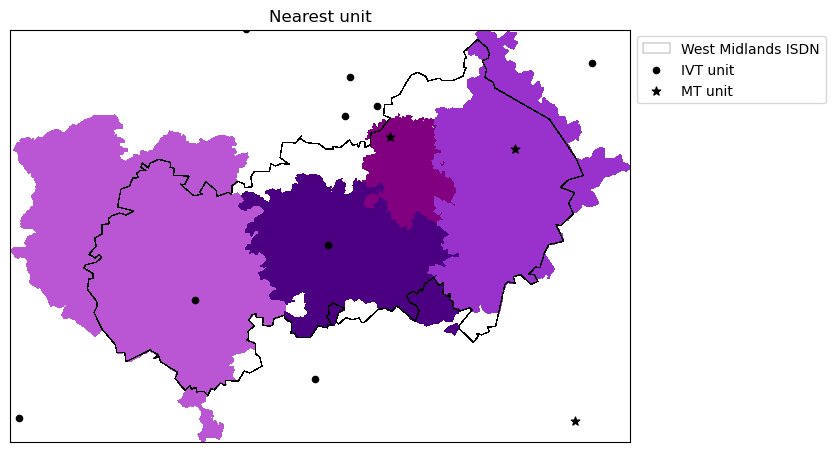

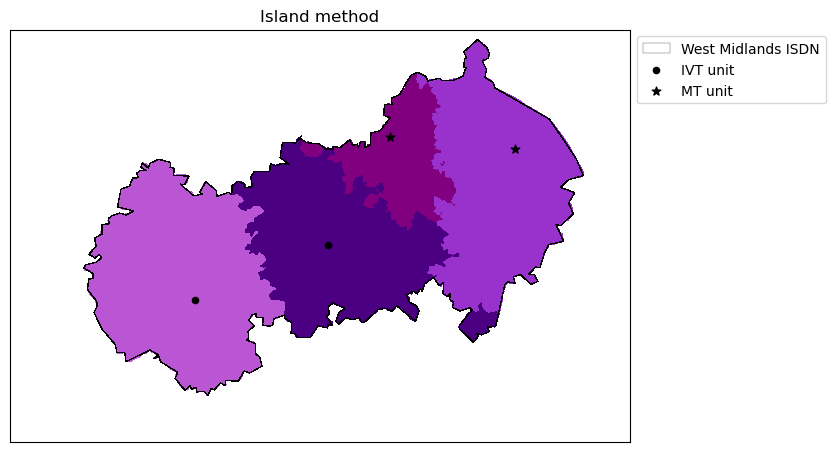

In [19]:
plot_catchment(gdf_catchment_acute, gdf_isdn, gdf_units, postcodes_acute_units, title='Nearest unit', bounds=bounds)
plot_catchment(gdf_catchment_island, gdf_isdn, gdf_units, postcodes_island, title='Island method', bounds=bounds)